<a href="https://colab.research.google.com/github/RashaAlshawi/HFFPN/blob/main/haar_fused_adaptive_feature_pyramid_network_hffpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Haar-Fused Adaptive Feature Pyramid Network (HFFPN), a novel architecture designed for the semantic segmentation of deficiencies in culverts and sewer pipes. HFFPN integrates a bottom-up pathway that incorporates Inception-like blocks with varying filter sizes (3x3 and 5x5), parallel max-pooling, and additional spatial detection layers. This design enables the network to capture multi-scale features and fine structural details. Throughout the network, depth-wise separable convolutions are employed to reduce complexity. The top-down pathway of HFFPN focuses on generating high-resolution features through upsampling and information fusion using 1x1 and 3x3 depth-wise separable convolutions. HFFPN achieves state-of-the-art results with an Intersection over Union (IoU) score of 77.18%, surpassing prior methods by 8.9%. With the incorporation of Haar-like features, it achieves an impressive IoU of 94.75%, outperforming existing approaches by 29.9%, all while utilizing significantly fewer parameters. HFFPN thus provides a powerful and efficient solution for accurate semantic segmentation in challenging real-world scenarios.


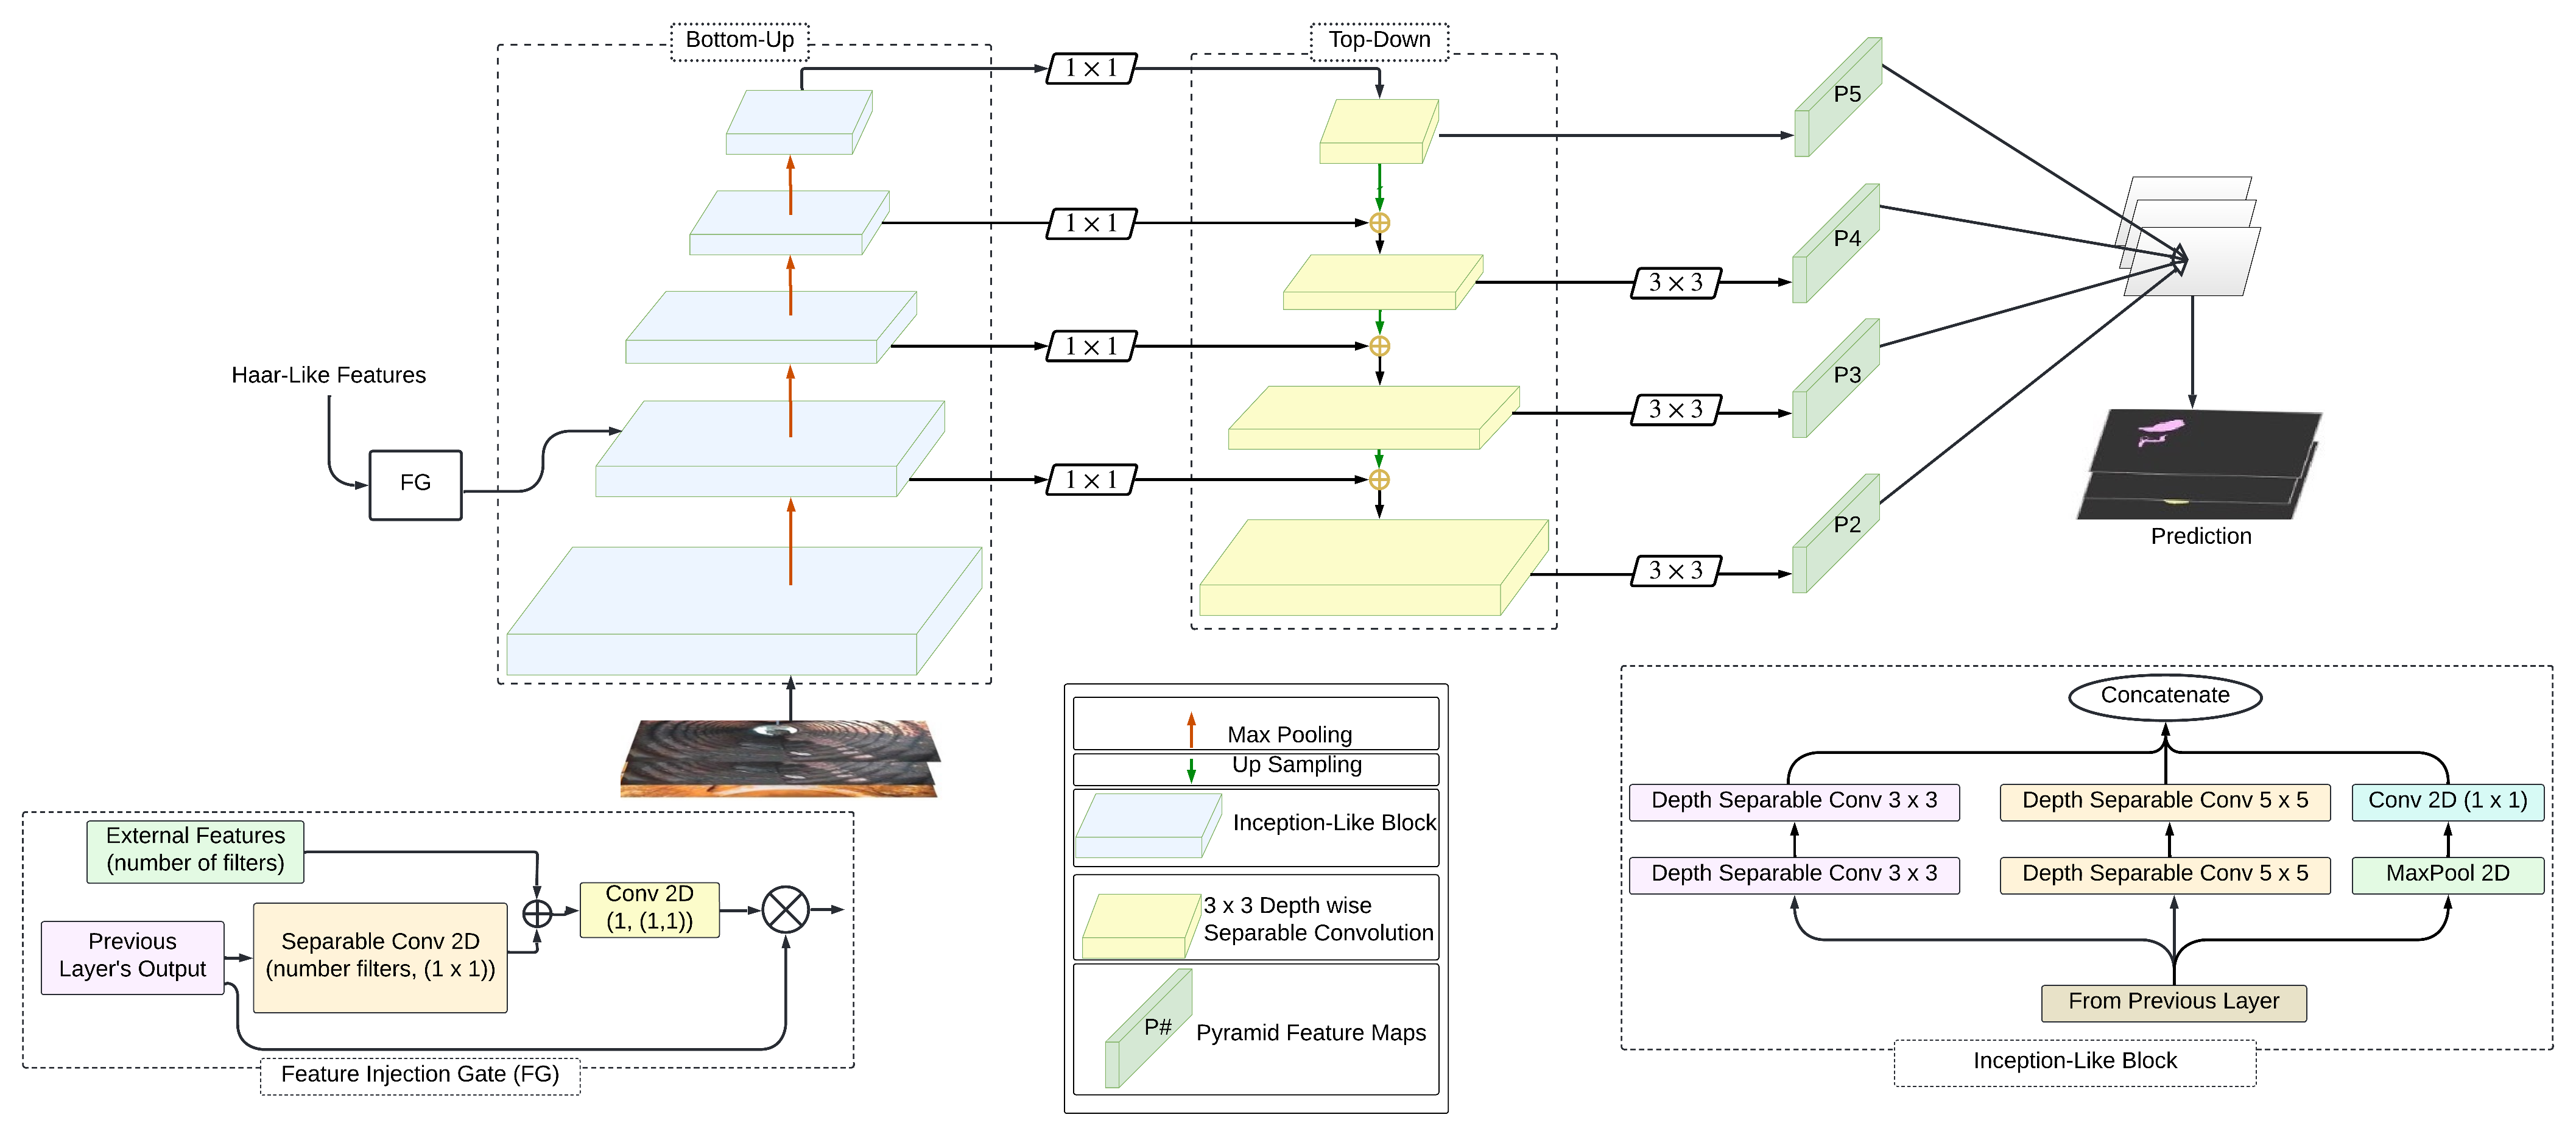

In [ ]:
#@title Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, SeparableConv2D,MaxPooling2D, concatenate, Conv2DTranspose,  BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers,layers
import math
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
import datetime
from keras.utils import to_categorical
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
pip install pyyaml h5py  # Required to save models in HDF5 format
from keras.models import load_model

#import tensorflow_addons as tfa

#Blocks

In [ ]:
def conv_block(inputs, filters, kernel_size=(3, 3), padding='same', activation=tf.nn.relu):
    conv = layers.SeparableConv2D(filters, kernel_size, padding=padding)(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = activation(conv)
    return conv

In [ ]:
#Depth Wise Separable Block
def inception_sepconvblock(inputs, f1, f2, f3):
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(conva)

    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(convb)

    convc = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    convc = Conv2D(f3, (1, 1), padding='same')(convc)

    concatenated = concatenate([conva, convb, convc])
    print(concatenated.shape)

    return concatenated

In [ ]:
#@title Base Base Adaptive-FPN Model
def build_fpn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Bottom-up pathway
    conv1 = inception_sepconvblock(inputs, f1=22, f2=21, f3=21)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = inception_sepconvblock(pool1, f1=44, f2=42, f3=42)  # 128x128
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = inception_sepconvblock(pool2, f1=86, f2=85, f3=85)  # 64x64
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = inception_sepconvblock(pool3, f1=171, f2=171, f3=170)  # 32x32
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = inception_sepconvblock(pool4, f1=342, f2=341, f3=341)  # 16x16

    # Top-down pathway
    # Merging and upsampling
    p5 = conv_block(conv5, 128, kernel_size=(1, 1))  # Reduce channel depth of conv5
    p4 = conv_block(conv4, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    p3 = conv_block(conv3, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p4)  # Upsampling factor adjusted

    p2 = conv_block(conv2, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p3)  # Upsampling factor adjusted

    # Prediction heads
    output_p3 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p3)
    output_p4 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p4)
    output_p5 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p5)
    output_p2 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p2)


    # Final prediction merging
    output1 = tf.keras.layers.UpSampling2D(size=(2, 2))(output_p2)+tf.keras.layers.UpSampling2D(size=(4, 4))(output_p3)+ tf.keras.layers.UpSampling2D(size=(8, 8))(output_p4) + tf.keras.layers.UpSampling2D(size=(16, 16))(output_p5)
    print('output',output1.shape)
    output = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(output1)
    print('output2',output.shape)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


In [ ]:
num_channels=5
input_shape2=(64,64,num_channels)
input_shape = (128, 128, 3)

In [ ]:
#@ FPN with Two Inputs- Haar-Fused Adaptive Feature Pyramid Network (HFFPN)


def build_fpn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    input2 = tf.keras.layers.Input(shape=input_shape2)


    # Bottom-up pathway
    conv1 = inception_sepconvblock(inputs, f1=22, f2=21, f3=21)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = inception_sepconvblock(pool1, f1=44, f2=42, f3=42)  # 128x128


    conv2_f=SeparableConv2D(num_channels, (1, 1), activation='linear')(conv2)
    conv2 =layers.LeakyReLU()(conv2_f + input2) # adding features using the proposed gate

    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(conv2)
    psi = layers.Activation('sigmoid')(psi)
    conv2 = conv2 * psi
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = inception_sepconvblock(pool2, f1=86, f2=85, f3=85)  # 64x64

    #max_features = tf.keras.layers.MaxPool2D((2, 2))(input2) # We can also add here too
    #conv3 = tf.concat([conv3, max_features], axis=-1)

    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = inception_sepconvblock(pool3, f1=171, f2=171, f3=170)  # 32x32
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = inception_sepconvblock(pool4, f1=342, f2=341, f3=341)  # 16x16

    # Top-down pathway
    # Merging and upsampling
    p5 = conv_block(conv5, 128, kernel_size=(1, 1))
    p4 = conv_block(conv4, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    p3 = conv_block(conv3, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p4)  # Upsampling factor adjusted

    p2 = conv_block(conv2, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p3)  # Upsampling factor adjusted

    # Prediction heads
    output_p3 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p3)
    output_p4 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p4)
    output_p5 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p5)
    output_p2 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p2)


    # Final prediction merging
    output1 = tf.keras.layers.UpSampling2D(size=(2, 2))(output_p2)+tf.keras.layers.UpSampling2D(size=(4, 4))(output_p3) + tf.keras.layers.UpSampling2D(size=(8, 8))(output_p4) + tf.keras.layers.UpSampling2D(size=(16, 16))(output_p5)
    print('output',output1.shape)
    output = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(output1)
    print('output2',output.shape)
    model = tf.keras.Model(inputs=[inputs,input2], outputs=[output])


    return model


In [ ]:
num_classes = 9 # Number of deficiencies in in our Culvert-Sewer dataset.

In [ ]:
model = build_fpn(input_shape, num_classes)
#model.summary()

(None, 128, 128, 64)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
output (None, 128, 128, 9)
output2 (None, 128, 128, 9)


In [ ]:
#@title Original FPN with ResNet Backbone
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(inputs, filters, kernel_size=(3, 3), padding='same', activation=tf.nn.relu):
    conv = layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = activation(conv)
    return conv

def build_fpn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Backbone network (e.g., ResNet)
    backbone = tf.keras.applications.ResNet50(input_tensor=inputs, include_top=False, weights='imagenet')

    # Feature pyramid network
    c3, c4, c5 = backbone.get_layer('conv3_block4_out').output, backbone.get_layer('conv4_block6_out').output, backbone.get_layer('conv5_block3_out').output

    # Top-down pathway
    p5 = conv_block(c5, 256, kernel_size=(1, 1))
    p4 = conv_block(c4, 256, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    p3 = conv_block(c3, 256, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p4)

    # Bottom-up pathway
    p4 = conv_block(p4, 256)
    p3 = conv_block(p3, 256)

    # Prediction heads
    output_p3 = layers.Conv2D(num_classes, (3, 3), padding='same', activation='softmax')(p3)
    output_p4 = layers.Conv2D(num_classes, (3, 3), padding='same', activation='softmax')(p4)
    output_p5 = layers.Conv2D(num_classes, (3, 3), padding='same', activation='softmax')(p5)

    # Final prediction merging
    output = tf.keras.layers.UpSampling2D(size=(8, 8))(output_p3) + tf.keras.layers.UpSampling2D(size=(16, 16))(output_p4) + tf.keras.layers.UpSampling2D(size=(32, 32))(output_p5)
    output = layers.Conv2D(num_classes, (3, 3), padding='same', activation='softmax')(output)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Example usage
input_shape = (128, 128, 3)  # Example input shape
num_classes = 9  # Example number of classes
model = build_fpn(input_shape, num_classes)
model.summary()


In [ ]:
#compute the number of trainable parameters
total_params = sum(np.prod(p.numpy().shape) for p in model.trainable_variables)
print("Total Trainable Parameters:", total_params)

#Load and Compile

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

Segmentation Models: using `tf.keras` framework.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
              ,run_eagerly=True


              ) #tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(),


In [ ]:
#@title Load Culver-Sewer Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_P=np.load('/content/drive/MyDrive/VideoFrames/PositiveImageNew.npy')
y_P=np.load('/content/drive/MyDrive/VideoFrames/PositivemaskNew.npy')

In [ ]:
# Import Haar Features
F1=np.load('/content/drive/MyDrive/.ipynb_checkpoints/haar_features_16_4_SquareMASK.npy')
F2=np.load('/content/drive/MyDrive/.ipynb_checkpoints/haar_features_4_2_SquareMASK.npy')
F3=np.load('/content/drive/MyDrive/.ipynb_checkpoints/haar_features_42_42_SquareDoubleALL.npy')
F4=np.load('/content/drive/MyDrive/.ipynb_checkpoints/HaarLine.npy')
F5=np.load('/content/drive/MyDrive/.ipynb_checkpoints/HaarLineV.npy')

In [ ]:
F1.shape,F2.shape,F3.shape,F4.shape,F5.shape,y_P.shape,X_P.shape

((5051, 128, 128),
 (5051, 128, 128),
 (5051, 128, 128),
 (5051, 128, 128),
 (5051, 128, 128),
 (5051, 128, 128),
 (5051, 128, 128, 3))

In [ ]:
# Expand the shape to match the training data
F1_exp = np.expand_dims(F1, axis=-1)  # New shape: (num_sapmles, 128, 128, 1)
F2_exp=np.expand_dims(F2, axis=-1)
F3_exp=np.expand_dims(F3, axis=-1)
F4_exp=np.expand_dims(F4, axis=-1)
F5_exp=np.expand_dims(F5, axis=-1)

In [ ]:
filterResposne = np.concatenate([F1_exp,F2_exp,F3_exp,F4_exp,F5_exp], axis=-1)

In [ ]:
filterResposne.shape

(5051, 128, 128, 5)

In [ ]:
#@title Resizing the second input
from skimage.transform import resize
# Example data
batch_size = filterResposne.shape[0]
height = 128
width = 128
num_channels = 5

# Define the desired height and width after resizing
desired_height = 64
desired_width = 64

# Initialize the output array to store the resized data
output_array = np.zeros((batch_size, desired_height, desired_width, num_channels), dtype=filterResposne.dtype)

# Resize each image in the input array to the desired size
for i in range(batch_size):
    for j in range(num_channels):
        output_array[i, :, :, j] = resize(filterResposne[i, :, :, j], (desired_height, desired_width), preserve_range=True)


In [ ]:
output_array.shape

(5051, 64, 64, 5)

In [ ]:
# Preparing The data for HFFPN
X_datas, y_datas, filter_responseShuffled = shuffle(X_P, y_P,output_array, random_state=10)

In [ ]:
#Preparing The data for The Base Adaptive-FPN
X_datas, y_datas = shuffle(X_P, y_P, random_state=10)

In [ ]:
#all
numClasses=9
train_masks_cat = to_categorical(y_datas, num_classes=numClasses)
y_train_cat_test = train_masks_cat.reshape((y_datas.shape[0], y_datas.shape[1], y_datas.shape[2], numClasses))

In [ ]:
#@title Dataset Normalization
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
X_datas_=normalize(X_datas)

In [ ]:
# Preparing The data for The Base Adaptive-FPN
samples_train = int(0.7 * len(X_datas_))
samples_val = int(0.15 * len(X_datas_))

X_train = X_datas_[:samples_train]
y_train = y_train_cat_test[:samples_train]

X_val = X_datas_[samples_train:samples_train + samples_val]
y_val = y_train_cat_test[samples_train:samples_train + samples_val]

X_test = X_datas_[samples_train + samples_val:]
y_test = y_train_cat_test[samples_train + samples_val:]

In [ ]:
# Preparing The data for HFFPN
samples_train = int(0.7 * len(X_datas_))
samples_val = int(0.15 * len(X_datas_))

X_train = X_datas_[:samples_train]
X_input2 = filter_responseShuffled[:samples_train]
y_train = y_train_cat_test[:samples_train]

X_val = X_datas_[samples_train:samples_train + samples_val]
X_val_input2=filter_responseShuffled[samples_train:samples_train + samples_val]
y_val = y_train_cat_test[samples_train:samples_train + samples_val]

X_test = X_datas_[samples_train + samples_val:]
X_test_inut2=filter_responseShuffled[samples_train + samples_val:]
y_test = y_train_cat_test[samples_train + samples_val:]

In [ ]:
#@title  Model Training and Evaluation
filepath='/content/drive/MyDrive/best'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

In [ ]:
%tensorboard --logdir log

In [ ]:
# Training HFFPN  with Two Inputs
history=model.fit(x=[X_train,X_input2],y=y_train,epochs=100,validation_data=([X_val, X_val_input2], y_val),batch_size=5,callbacks=my_callbacks)


Epoch 1/100


707/707 [==============================] - 196s 257ms/step - loss: 0.4217 - iou_score: 0.6552 - f1-score: 0.6609 - val_loss: 0.1460 - val_iou_score: 0.7133 - val_f1-score: 0.7254
Epoch 2/100
707/707 [==============================] - 182s 258ms/step - loss: 0.1153 - iou_score: 0.7154 - f1-score: 0.7320 - val_loss: 0.0793 - val_iou_score: 0.8262 - val_f1-score: 0.8552
Epoch 3/100
707/707 [==============================] - 182s 258ms/step - loss: 0.0711 - iou_score: 0.8040 - f1-score: 0.8324 - val_loss: 0.0598 - val_iou_score: 0.8544 - val_f1-score: 0.8784
Epoch 4/100
707/707 [==============================] - 182s 257ms/step - loss: 0.0587 - iou_score: 0.8247 - f1-score: 0.8507 - val_loss: 0.0425 - val_iou_score: 0.8689 - val_f1-score: 0.8913
Epoch 5/100
707/707 [==============================] - 181s 256ms/step - loss: 0.0418 - iou_score: 0.8486 - f1-score: 0.8724 - val_loss: 0.0312 - val_iou_score: 0.8812 - val_f1-score: 0.9027
Epoch 6/100
707/707 [==============================] - 17

In [ ]:
#Training The Base Adaptive-FPN
history=model.fit(x=[X_train],y=y_train,epochs=100,validation_data=([X_val], y_val),batch_size=5)#,callbacks=my_callbacks)

Epoch 1/100


707/707 [==============================] - 177s 230ms/step - loss: 0.5284 - iou_score: 0.6465 - f1-score: 0.6507 - val_loss: 0.3951 - val_iou_score: 0.6561 - val_f1-score: 0.6600
Epoch 2/100
707/707 [==============================] - 160s 226ms/step - loss: 0.3432 - iou_score: 0.6523 - f1-score: 0.6573 - val_loss: 0.3088 - val_iou_score: 0.6579 - val_f1-score: 0.6628
Epoch 3/100
707/707 [==============================] - 159s 225ms/step - loss: 0.2749 - iou_score: 0.6619 - f1-score: 0.6727 - val_loss: 0.2566 - val_iou_score: 0.6753 - val_f1-score: 0.6900
Epoch 4/100
707/707 [==============================] - 160s 226ms/step - loss: 0.2305 - iou_score: 0.6659 - f1-score: 0.6794 - val_loss: 0.2106 - val_iou_score: 0.6854 - val_f1-score: 0.7019
Epoch 5/100
707/707 [==============================] - 160s 226ms/step - loss: 0.1973 - iou_score: 0.6790 - f1-score: 0.6941 - val_loss: 0.1958 - val_iou_score: 0.6701 - val_f1-score: 0.6824
Epoch 6/100
707/707 [==============================] - 16

In [ ]:
c=pd.DataFrame(history.history)
c.to_csv('/content/drive/MyDrive/Fall20/ALlFIveFeatuesofHaa2')

<Axes: >

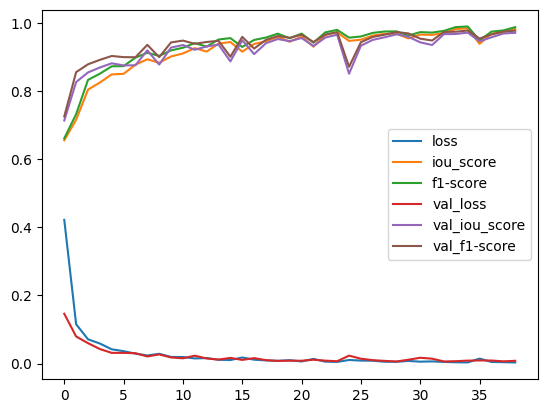

In [ ]:
c.plot() #

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/VideoFrames/DS/ALlFIveFeatuesofHaa2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the trained model

model = tf.keras.load_model(filepath+".h5",compile=True)

In [ ]:
model.evaluate([X_test,X_test_inut2])#[0.4265437722206116, 0.8815105557441711, 0.717641294002533]

24/24 [==============================] - 2s 72ms/step - loss: 0.0000e+00 - iou_score: 0.0000e+00 - f1-score: 0.0000e+00


[0.0, 0.0, 0.0]

In [ ]:
#y_predict=model.predict([X_test])
y_predict=model.predict([X_test,X_test_inut2])

24/24 [==============================] - 2s 71ms/step


In [ ]:
y_predict_=np.argmax(y_predict, axis=-1)

In [ ]:
y_test_=np.argmax(y_test, axis=3)

# Metrics- Model Evaluation



In [ ]:
# Frequency Weighted Intersection over Union
def calculate_fwiou(predicted_mask, ground_truth_mask, class_frequencies):

    predicted_flat = K.flatten(predicted_mask)
    ground_truth_flat = K.flatten(ground_truth_mask)

    unique_classes = np.unique(ground_truth_flat)

    intersection_sum = 0
    union_sum = 0

    for class_val in unique_classes:
        class_mask = K.equal(ground_truth_flat, class_val)
        intersection = K.sum(K.cast(predicted_flat[class_mask] == class_val, K.floatx()))
        union = K.sum(K.cast((predicted_flat == class_val) | class_mask, K.floatx()))
        frequency = class_frequencies[class_val]

        intersection_sum += frequency * intersection
        union_sum += frequency * union

    fwiou = intersection_sum / union_sum

    return fwiou


In [ ]:
class_frequencies = {0: 0.0,
                    1: 1, # crack
                     2: 1, # Hole
                     3: 1, #root
                     4: 0.1622,#deformation
                     5:0.7100 , #fracture
                     6: 0.3518, #erosion
                     7: 0.6419, #joints
                     8: 0.5419 #loose gasket
                     }




In [ ]:

fwiou = calculate_fwiou(y_predict_, y_test_, class_frequencies)#0.7686044573783875
print(f"FWIoU: {fwiou}")

FWIoU: 0.9668901562690735


In [ ]:
# Define the mapping of object colors to RGB values
color_map = {
    0: [0, 0, 0],        # Background color
    1: [192, 209, 249],  # crack
    2: [191, 191, 191],  # hole
    3: [254, 255, 126],  # root
    4: [247, 205, 160],  # Deformation
    5:[246,202,255],  # Fracture
    6: [139, 2, 223],  # Erosion
    7: [188, 252, 176],  # joints
    8: [243,172,0] #loose_gasket

}

ALlFIveFeatuesofHaar 88


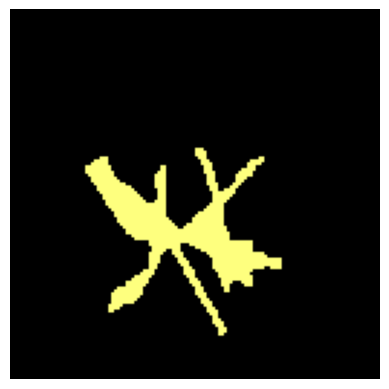

In [ ]:
#Sampels: 10, 20, 26, 50, 57, 88, 83
#samples: 199, 78,1,3,26, 50,88
i=88
print('ALlFIveFeatuesofHaar',i)
image = y_predict_[i]
# Map the object colors to RGB colors
rgb_imageP = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_imageP[i, j] = color_map[image[i, j]]
plt.axis('off')
plt.imshow(rgb_imageP);

Real: 3
[0 7]


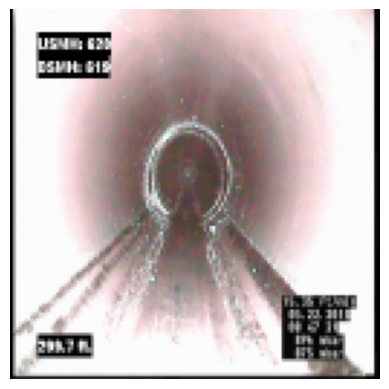

 Ground truth: 127


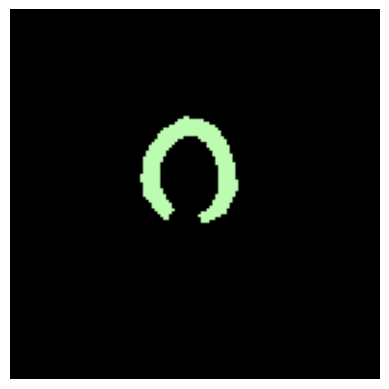

In [ ]:
i=3
image = y_test_[i]
print('Real:',i)
plt.axis('off')
plt.imshow(X_test[i])
print(np.unique( y_test_[i]))
plt.show()
# Map the object colors to RGB colors
rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_image[i, j] = color_map[image[i, j]]

print(' Ground truth:',i)
plt.axis('off')
plt.imshow(rgb_image)

In [ ]:
# Calculate the F1 score for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
f1_scores = {}
for class_value in unique_classes:
    binary_y_true = (y_true_flat == class_value)
    binary_y_pred = (y_pred_flat == class_value)
    f1_scores[class_value] = f1_score(binary_y_true, binary_y_pred)

# Print the F1 scores for each class
for class_value, f1_score_value in f1_scores.items():
    print(f"F1 Score for class {class_value}: {f1_score_value}")
# average f1_scores for all classes
average_F1_all = np.mean(list(f1_scores.values()))
print(f"Average f1_scores (including class 0): {average_F1_all}")
# average f1_scores excluding class 0
F1_scores_without_class_0 = {k: v for k, v in f1_scores.items() if k != 0}
average_F1_without_class_0 = np.mean(list(F1_scores_without_class_0.values()))
print(f"Average F1 (excluding class 0): {average_F1_without_class_0}")


F1 Score for class 0: 0.9994533626974723
F1 Score for class 1: 0.9846865221464115
F1 Score for class 2: 0.9978307446886617
F1 Score for class 3: 0.9918565872129407
F1 Score for class 4: 0.9620241664395385
F1 Score for class 5: 0.9874049396252408
F1 Score for class 6: 0.9489523555318297
F1 Score for class 7: 0.9768119505060862
F1 Score for class 8: 0.9010593204828804
Average f1_scores (including class 0): 0.9722311054812293
Average F1 (excluding class 0): 0.9688283233291988


In [ ]:
# Calculate the IoU for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
iou_scores = {}
for class_value in unique_classes:
    intersection = np.sum((y_true_flat == class_value) & (y_pred_flat == class_value))
    union = np.sum((y_true_flat == class_value) | (y_pred_flat == class_value))

    iou_scores[class_value] = intersection / union

# Print the IoU scores for each class
for class_value, iou_score in iou_scores.items():
    print(f"IoU for class {class_value}: {iou_score}")

# average IoU for all classes
average_iou_all = np.mean(list(iou_scores.values()))
print(f"Average IoU (including class 0): {average_iou_all}")

# average IoU excluding class 0
iou_scores_without_class_0 = {k: v for k, v in iou_scores.items() if k != 0}
average_iou_without_class_0 = np.mean(list(iou_scores_without_class_0.values()))
print(f"Average IoU (excluding class 0): {average_iou_without_class_0}")


IoU for class 0: 0.99890732269312
IoU for class 1: 0.969834975724026
IoU for class 2: 0.9956708803431327
IoU for class 3: 0.983844733430244
IoU for class 4: 0.9268271334792123
IoU for class 5: 0.9751232039980565
IoU for class 6: 0.9028633102660149
IoU for class 7: 0.9546749016363453
IoU for class 8: 0.8199344489447878
Average IoU (including class 0): 0.9475201011683265
Average IoU (excluding class 0): 0.9410966984777274


In [ ]:
label_mapping = {
    'background': 0,
    'crack': 1,
    'spiral_crack': 1,
    'hole': 2,
    'root': 3,
    'roots': 3,
    'Pipe_Deformed': 4,
    'deformation': 4,
     'fracture': 5,
    'erosion': 6,
     'encrustation': 6,
    'joint': 7,'joints':7,
    'joint_offset':7,'offset':7,
     'loose_gasket':8
}


In [ ]:

def calculate_pixel_acc(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Input arrays must have the same shape."

    total_pixels = np.prod(y_true.shape)
    correct_pixels = np.sum(y_true == y_pred)

    pixel_acc = correct_pixels / total_pixels

    return pixel_acc


In [ ]:
pixel_acc = calculate_pixel_acc(y_test_, y_predict_)
print("Pixel Accuracy:", pixel_acc)

Pixel Accuracy: 0.9931966306663784


In [ ]:
def calculate_balanced_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    num_classes = 9

    class_accuracies = []

    for cls in unique_classes:
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)

        class_accuracy = np.sum(true_mask & pred_mask) / np.sum(true_mask)
        class_accuracies.append(class_accuracy)

    balanced_acc = np.mean(class_accuracies)
    return balanced_acc


In [ ]:
calculate_balanced_accuracy(y_test_, y_predict_)

In [ ]:

#  Matthews correlation coefficient (MCC)
num_samples, height, width = y_test_.shape
num_classes = 9

# Reshape the arrays to 1D (num_samples * height * width,)
y_true_flat = y_test_.ravel()
y_pred_flat = y_predict_.ravel()

# Calculate  MCC for each class
mcc_scores = []
for class_idx in range(num_classes):
    class_true = (y_true_flat == class_idx)
    class_pred = (y_pred_flat == class_idx)
    mcc = matthews_corrcoef(class_true, class_pred)
    mcc_scores.append(mcc)

# Calculate  average MCC across all classes
mean_mcc = np.mean(mcc_scores)
mean_mcc

0.9335456935199056